In [1]:
import requests
from time import sleep

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = 'notebook' 

In [9]:
df = pd.read_excel(r"C:\Users\Sofiya\Downloads\Telegram Desktop\Реестр.xlsx", engine="openpyxl", header = 2, nrows = 200000, usecols = [i for i in range(1, 7)])
df.head(6)

C:\Users\Sofiya\PycharmProjects\pythonProject\course_analysis\venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности
0,""" МЕГАПОЛИС "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВ...",Юридическое лицо,Не является субъектом МСП,1027800523376,7801190028,41.2 Строительство жилых и нежилых зданий
1,""" СТАЛЬИНВЕСТСТРОЙ "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1037800033545,7801227976,41.20 Строительство жилых и нежилых зданий
2,""" СТРОЙТЕХНИКА - М "" ОБЩЕСТВО С ОГРАНИЧЕННОЙ О...",Юридическое лицо,Не является субъектом МСП,1025204418293,5263039399,41.20 Строительство жилых и нежилых зданий
3,"""БАЗИС"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Микропредприятие,1025204411682,5263025484,41.20 Строительство жилых и нежилых зданий
4,"""БЕЛАГ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Не является субъектом МСП,1037800039276,7801123215,41.20 Строительство жилых и нежилых зданий
5,"""БЕРЕГ"" ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ",Юридическое лицо,Микропредприятие,1035010950633,5056003490,41.20 Строительство жилых и нежилых зданий


In [10]:
print(len(df))
df_f = df[
    (df["Тип субъекта"] == "Юридическое лицо") &
    (df["Категория"].str.startswith(("Малое", "Среднее"))) & 
    (df["Основной вид деятельности"].str.startswith(('41.20')))
]
df_f = df_f.reset_index(drop=True)
print(len(df_f))
df_f.head(8)

200000
1552


,Наименование / ФИО,Тип субъекта,Категория,ОГРН,ИНН,Основной вид деятельности
0,"""КОРПОРАЦИЯ ВИТ"" (ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕ...",Юридическое лицо,Малое предприятие,1025004907080,5038038838,41.20 Строительство жилых и нежилых зданий
1,"""ХОЗРАСЧЕТНАЯ СТРОИТЕЛЬНО-ТЕХНОЛОГИЧЕСКАЯ ФИРМ...",Юридическое лицо,Среднее предприятие,1025007270551,5027006369,41.20 Строительство жилых и нежилых зданий
2,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""777""",Юридическое лицо,Малое предприятие,1021400692048,1414006922,41.20 Строительство жилых и нежилых зданий
3,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АГРОТЕХИМПОРТ""",Юридическое лицо,Малое предприятие,1043301806415,3327332190,41.20 Строительство жилых и нежилых зданий
4,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКС""",Юридическое лицо,Малое предприятие,1027807999988,7816061297,41.20 Строительство жилых и нежилых зданий
5,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АКЦИОНЕРНАЯ ПРОИЗВОДСТВЕ...",Юридическое лицо,Малое предприятие,1023500875870,3525048992,41.20 Строительство жилых и нежилых зданий
6,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АЛЕКСЕЕВСКАЯ ПЕРЕДВИЖНАЯ...",Юридическое лицо,Малое предприятие,1023101533883,3101000612,41.20 Строительство жилых и нежилых зданий
7,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""АМБЕР-СТРОЙСЕРВИС""",Юридическое лицо,Малое предприятие,1025900534406,5902126804,41.20 Строительство жилых и нежилых зданий


In [11]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'application/json',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Referer': 'https://bo.nalog.ru/',
}


session = requests.Session()
ebitd = dict()
for inn in df_f['ИНН']:
    res = session.get(f'https://bo.nalog.gov.ru/advanced-search/organizations/search?query={inn}&page=0&size=20', headers = headers, timeout=6).json()
    if res['content']:
        org_id = res["content"][0]["id"]
        response = session.get(f"https://bo.nalog.gov.ru/nbo/organizations/{org_id}/bfo/", timeout=6, headers=headers).json()
        addr = response[0]['organizationInfo']['address']
        ebitd[inn] = dict()
        ebitd[inn]['Адрес'] = addr 
        for i in range(len(response)):
            year = response[i]['period']
            if response[i]['typeCorrections'][0]['correction'].get('financialResult', 0):
                fin_res = response[i]['typeCorrections'][0]['correction']['financialResult']
                EBITD = fin_res.get('current2400', 0)+fin_res.get('current2410', 0)+fin_res.get('current2330', 0) 
                ebitd[inn][year] = EBITD
       

In [59]:
df_ebitd = pd.DataFrame.from_dict(ebitd, orient='index')
df_ebitd = df_ebitd.reset_index().rename(columns={'index': 'ИНН'})
df_ebitd = df_ebitd[['ИНН', 'Адрес', '2020', '2021', '2022', '2023', '2024']]


print(len(df_ebitd))
df_ebitd.head(20)


1540


,ИНН,Адрес,2020,2021,2022,2023,2024
0,5038038838,"141207, Московская обл, г Пушкино, ул Чехова, ...",14160.0,8361.0,19323.0,-17827.0,-18799.0
1,5027006369,"140093, Московская обл, Дзержинский г, Угрешск...",21562.0,14913.0,25665.0,438758.0,21519.0
2,1414006922,"678144, Саха /Якутия/ респ, Ленский муниципаль...",-790.0,-3728.0,-558.0,11265.0,37913.0
3,3327332190,"Владимир г, Александра Матросова ул, 1, 600005",14218.0,15005.0,22681.0,30076.0,34262.0
4,7816061297,"192102, Город Санкт-Петербург, вн.тер. г. Муни...",4292.0,769.0,332.0,706.0,14649.0
5,3525048992,"160001, Вологодская обл, г Вологда, ул Благове...",-10922.0,5910.0,11425.0,126298.0,35067.0
6,3101000612,"309857, Белгородская обл, р-н Алексеевский, г ...",-3824.0,-3064.0,-13022.0,-15367.0,-22193.0
7,5902126804,"614022, Пермский край, Пермь г, Мира ул, дом 4...",-13549.0,10084.0,4513.0,739.0,25243.0
8,523005733,"368780, Дагестан Респ, р-н Магарамкентский, с ...",-3396.0,317.0,1154.0,1286.0,1738.0
9,7724745755,"127566, Москва г, ш Алтуфьевское, 48, 1, Эт 9 ...",31991.0,-3235.0,17024.0,25595.0,97345.0


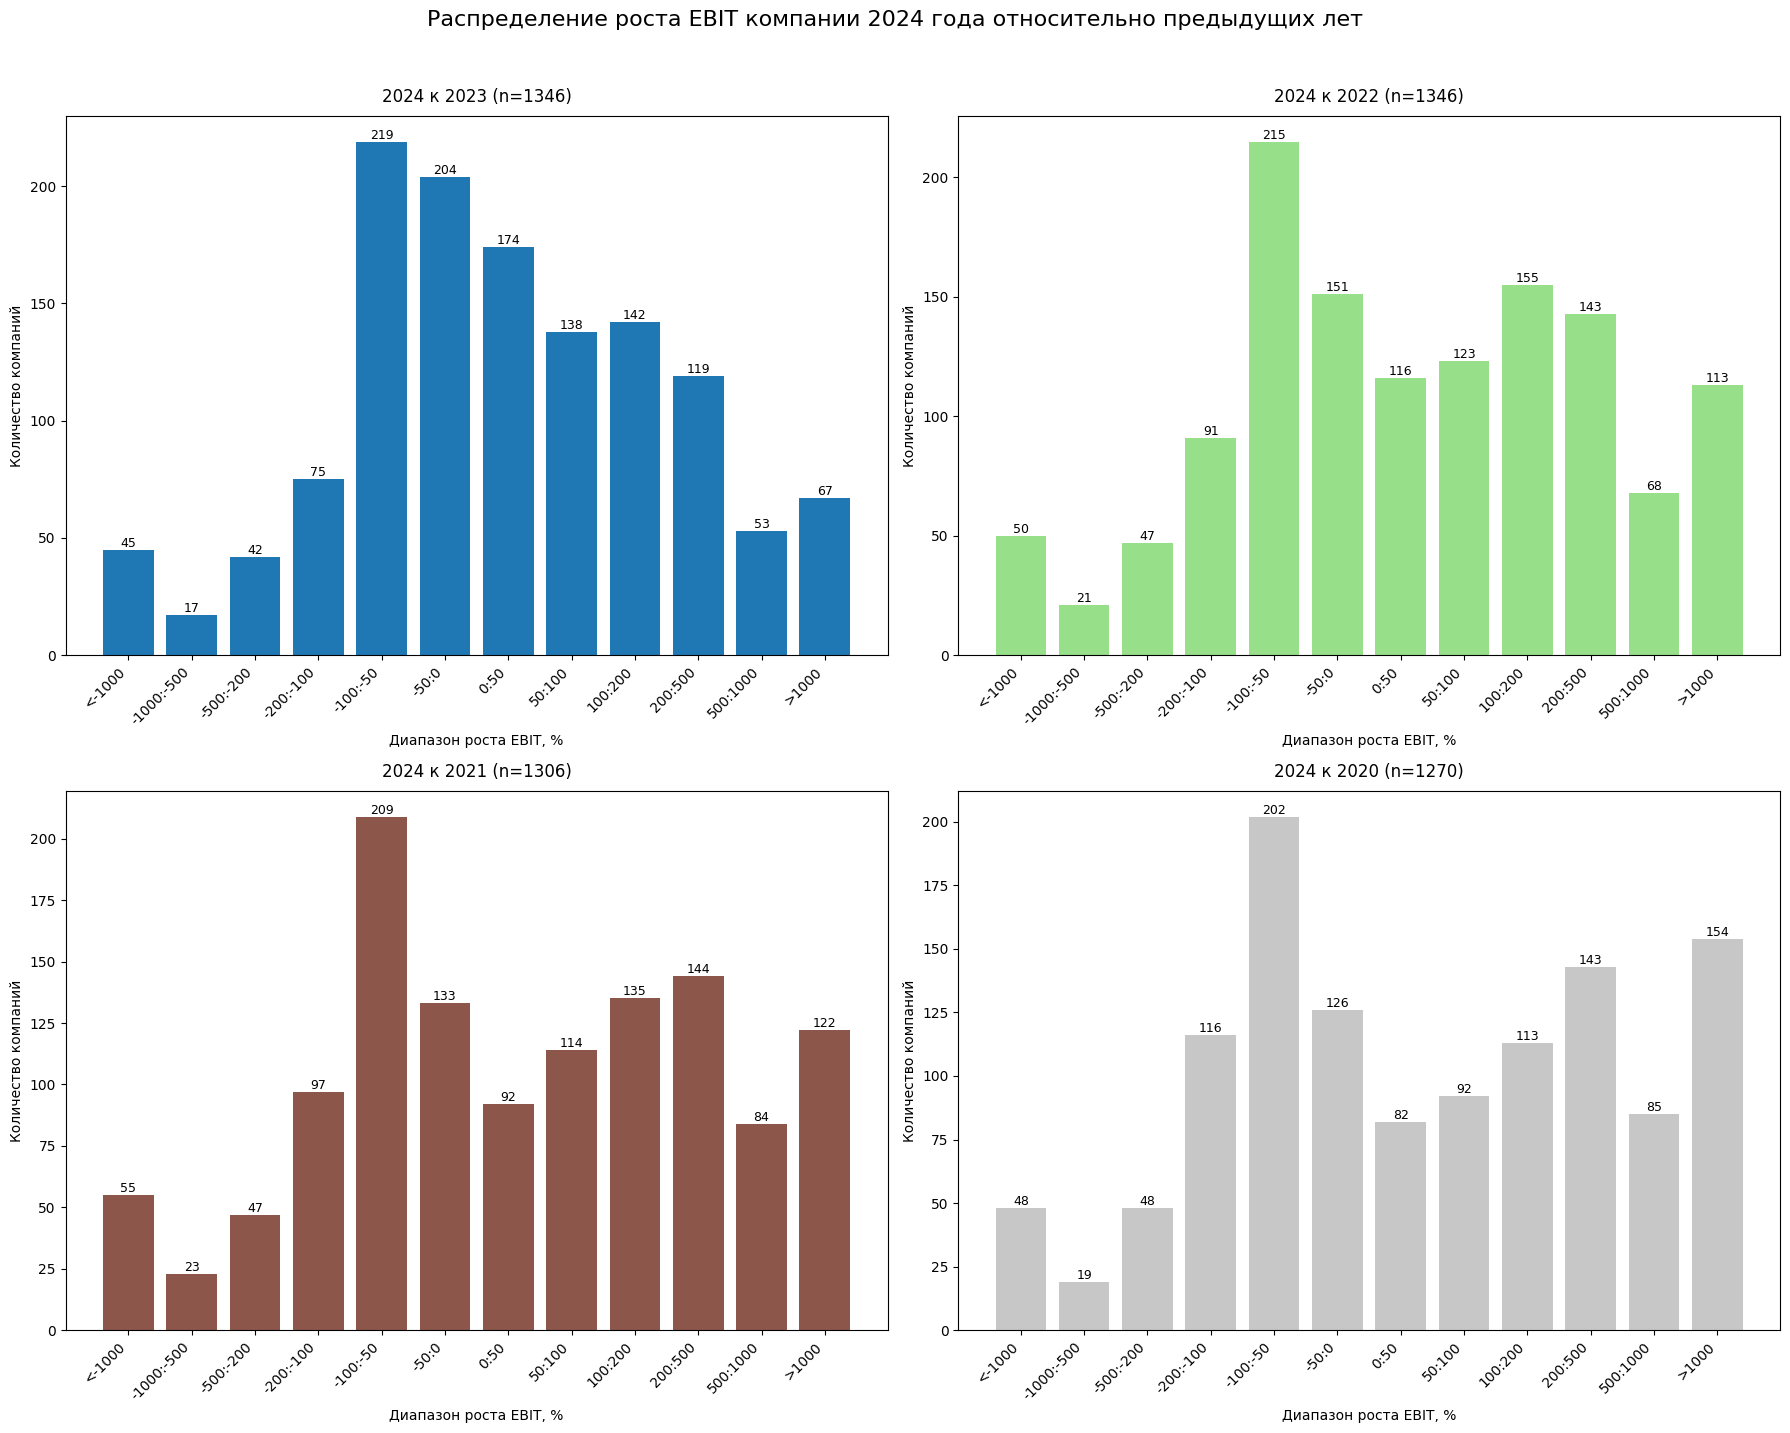

  Годы сравнения  Количество компаний Доля от общего числа
0   2024 vs 2023                 1346                87.4%
1   2024 vs 2022                 1346                87.4%
2   2024 vs 2021                 1306                84.8%
3   2024 vs 2020                 1270                82.5%


Text(0.5, 0, 'год')

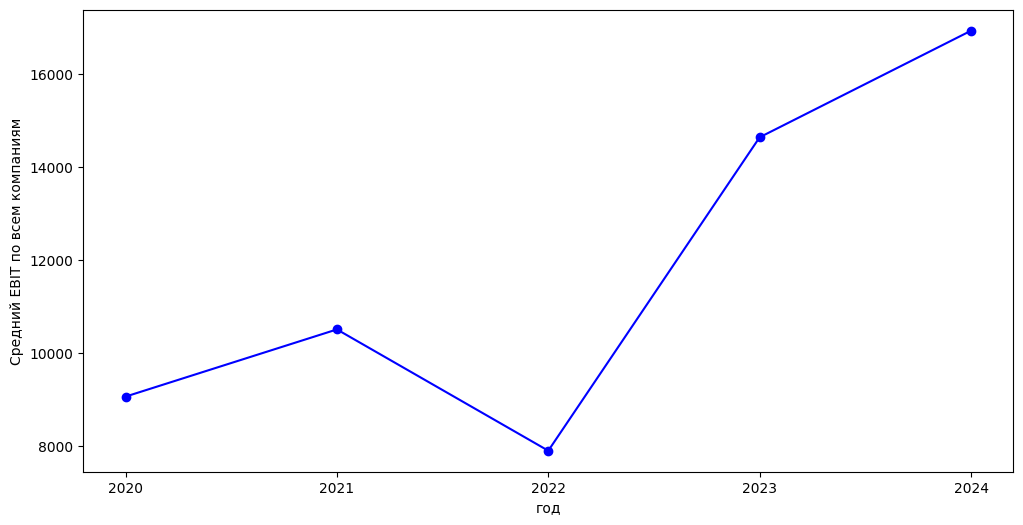

In [48]:
def calculate_growth(current, previous):
    conditions = [
        (previous > 0) & (current > 0),
        (previous < 0) & (current < 0),
        (previous < 0) & (current > 0),
        (previous > 0) & (current < 0)   
    ]
    
    choices = [
        (current - previous) / previous * 100,
        (current - previous) / abs(previous) * 100,
        (current + abs(previous)) / abs(previous) * 100,
        -(abs(current) + previous) / previous * 100
    ]
    
    return np.select(conditions, choices, default=np.nan)


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Распределение роста EBIT компании 2024 года относительно предыдущих лет', fontsize=16, y=1.02)


base_year = '2024'
compare_years = ['2023', '2022', '2021', '2020']
bins = [-np.inf, -1000, -500, -200, -100, -50, 0, 50, 100, 200, 500, 1000, np.inf]
labels = ['<-1000', '-1000:-500', '-500:-200', '-200:-100', '-100:-50', 
          '-50:0', '0:50', '50:100', '100:200', '200:500', '500:1000', '>1000']

for i, compare_year in enumerate(compare_years):
    ax = axes[i//2, i%2]
    mask = df_ebitd[[base_year, compare_year]].notna().all(axis=1)
    filtered_df = df_ebitd.loc[mask].copy()
    filtered_df['Рост_EBIT_%'] = calculate_growth(filtered_df[base_year], filtered_df[compare_year])
    filtered_df['Группа_роста'] = pd.cut(filtered_df['Рост_EBIT_%'], bins=bins, labels=labels)
    growth_counts = filtered_df['Группа_роста'].value_counts().sort_index()
    bars = ax.bar(growth_counts.index, growth_counts, color=plt.cm.tab20(i/4))
    ax.set_title(f'2024 к {compare_year} (n={len(filtered_df)})', pad=10)
    ax.set_xlabel('Диапазон роста EBIT, %')
    ax.set_ylabel('Количество компаний')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


summary_data = []
for compare_year in compare_years:
    mask = df_ebitd[[base_year, compare_year]].notna().all(axis=1)
    count = mask.sum()
    summary_data.append({'Годы сравнения': f'2024 vs {compare_year}', 
                         'Количество компаний': count,
                         'Доля от общего числа': f"{count/len(df_ebitd)*100:.1f}%"})

print(pd.DataFrame(summary_data))

avg = df_ebitd[['2020', '2021', '2022', '2023', '2024']].mean()
m = df_ebitd[[base_year, compare_year]].notna().all(axis=1)
fil_df = df_ebitd.loc[m].copy()
plt.figure(figsize=(12, 6))
plt.plot(avg.index, avg.values, 
         marker='o', 
         color='blue')
plt.ylabel('Средний EBIT по всем компаниям')
plt.xlabel('год')

In [78]:

сравнение:
2024 к 2020:
доминируют 2 группы: сильный рост(>10000%) и понижение показателя ebit (-100:-50)
в 2020 году был разгар пандемии, вводился карантин, остановка производства и услуг, компании терпели убытки,
по этому на фоне 2020 года в 2024 году параметр EBIT сильно увеличился, но тогда же активно вводились меры гос поддержки строительной отрасли,
поэтому к 2024 году ebit компаний мог улучшиться

2024 к 2021:
доминирует 1 группа: понижение показателя ebit (-100:-50)  
рост цен относительно 2021 года, дефицит рабочих кадров, падение спроса на жилье из за высокой ключевой ставки, 
санкции и проблемы с поставками могут обосновать понижение показателя ebit.

2024 к 2022:
доминирует 1 группа: понижение показателя ebit (-100:-50)
кроме доминирующей группы следующие два показателя это понижение ebit(-50:0) и увеличение ebitd(100:200)
из за возникшей политической ситуации, санцкий против страны и потери части рабочей силы 
компании, ухода инвесторов, могли потерпеть убыток в 2024 году по сравнению с 2022 

2024 к 2023:
высокие показатели сместились больше к центру графика это говорит о нормализации значения ebit. 2023 был рекордным по количесвту ввода жилья, 
такие темпы строительства и ввода жилья обусловлены, в том числе, мерами государственной поддержки строительной отрасли, 
которые за последние годы были направлены на стимулирование спроса и предложения на рынке жилья за счет реализации отдельных
программ поддержки застройщиков, программ льготного ипотечного кредитования граждан, сокращения административных процедур, 
поддержки инфраструктурных проектов.

график средних значений ebit за 5 лет:
2021 год: Значительный рост до примерно 10 000, что может свидетельствовать о восстановлении после возможного кризиса или успешной адаптации компаний.
резкое падение в 2022: Снижение на 24.8% (до 7 903), вероятно, из-за внешних шоков (санкции, кризис, рост затрат)
в 2023 году: восстановление после кризиса
в 2024 году рост, который указывает на устойчивое улучшение.

Общий вывод: отрасль циклична, но способна быстрому восстановлению 

In [82]:
sorted_df_ebitd =df_ebitd.sort_values(by='2024',ascending=False) 

df_500 = sorted_df_ebitd.iloc[:500,:]
df_500.head(20)

,ИНН,Адрес,2020,2021,2022,2023,2024
79,9715426146,"127015, Москва г, ул Новодмитровская, д 2, к 2...",NaN,NaN,97897.0,584293.0,1650866.0
35,7714046959,"123007, Москва г, вн.тер.г. муниципальный окру...",340845.0,265471.0,68717.0,256018.0,1477262.0
139,7705014485,"109428, Москва г, пр-кт Рязанский, 22, 2",-350.0,42121.0,-34916.0,-71229.0,1061855.0
861,4703142292,"188660, Ленинградская обл., Всеволожский р-н, ...",-2551.0,286042.0,-237929.0,969479.0,859028.0
171,7712103721,"107061, Москва г, ул Хромова, д 20",25302.0,3802.0,13797.0,-40953.0,847031.0
136,1001010821,"185000, Карелия Респ, г Петрозаводск, пр-кт Пе...",438258.0,333067.0,443842.0,666499.0,731230.0
1330,7813350741,"199178, Санкт-Петербург г, Малый В.О. пр-кт, д...",-410.0,-6365.0,-2032.0,-89.0,566208.0
117,6731028404,"214014, Смоленская обл, Смоленск г, Энгельса у...",268190.0,318123.0,123272.0,329706.0,470821.0
915,9715403974,"127254, Москва г, ул Добролюбова, 21а, А, Поме...",NaN,30127.0,33383.0,400770.0,455264.0
128,2129003280,"428022, Чувашская Республика - Чувашия, Чебокс...",226862.0,250950.0,273129.0,234834.0,419544.0


In [97]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept': 'application/json',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
}

def get_coordinates(query):
    coords = session.get(f"https://nominatim.openstreetmap.org/search?q={query}&format=jsonv2",timeout=7,headers=headers).json()
    if coords:
        return coords[0]['lon'], coords[0]['lat']
    return None, None
    
lon = []
lat = []
session = requests.Session()

for inn in df_500['ИНН']:
    print(f"{inn}")
    res = session.get(f'https://bo.nalog.gov.ru/advanced-search/organizations/search?query={inn}&page=0&size=20',headers=headers,timeout=6).json()
    org_id = res["content"][0]["id"] 
    response = session.get(f"https://bo.nalog.gov.ru/nbo/organizations/{org_id}",timeout=6,headers=headers).json()
    queries = []
    if response.get('city'):
        queries.append(response['city'])
    if response.get('district'):
        queries.append(response['district'])
    if response.get('region'):
        queries.append(response['region'])
    
    found = False
    for query in queries:
        lon_val, lat_val = get_coordinates(query)
        if lon_val and lat_val:
            lon.append(lon_val)
            lat.append(lat_val)
            found = True
            break
    
    if not found:
        lon.append(None)
        lat.append(None)
        print(f"Координаты не найдены для  {inn}") 
    

df_500['lon'] = lon
df_500['lat'] = lat
        

9715426146
7714046959
7705014485
4703142292
7712103721
1001010821
7813350741
6731028404
9715403974
2129003280
3128001437
7810255553
4632297547
7723906368
6674164790
5509006942
9201519498
1215048572
7701529116
2128007123
7704027964
7751006190
7706424276
274106224
3906205764
5003110787
5016018436
2801048449
5256137268
3906175051
5024219496
4205313611
7703400936
2703009610
4220032291
2543028394
4401159638
7816300957
7105523240
275922105
3234040815
6679157757
7804403002
5410112902
6646008630
7810791610
7810855374
3444259931
7720693400
7838030937
6732209160
7713748105
2724075519
7701866545
7816131635
1655211533
3460059841
7733732294
6229032892
5904243246
6027099196
2225151436
1633607740
2311251522
5906102890
1215014090
7203538206
3235001826
6167100035
5406631510
2310111297
5032071564
7724745755
4823003533
7716922376
2308114879
3801993892
7203151985
2801016951
7453326003
6229084717
7801631836
7724403783
5027256182
7203258350
7724939253
6663071832
7719741321
3329011322
5837066398
3906366698
3

C:\Users\Sofiya\AppData\Local\Temp\ipykernel_3860\2953200983.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Sofiya\AppData\Local\Temp\ipykernel_3860\2953200983.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:


df_500.loc[:, 'lon'] = df_500['lon'].astype(float)
df_500.loc[:, 'lat'] = df_500['lat'].astype(float)
print(df_500[['lon', 'lat']].dtypes)

lon    object
lat    object
dtype: object


In [102]:
fig = px.scatter_map(df_500, lat="lat", lon="lon", hover_name="ИНН",
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(map_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()